In [9]:
import json
import pprint
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree
import collections
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,accuracy_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import itertools
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import Ridge,Lasso,ElasticNet
from sklearn.model_selection import GridSearchCV
import datetime, time
import pytz
import statsmodels.api as stats_api
import os
import csv

In [2]:
pp = pprint.PrettyPrinter(indent=2)
with open('tweet_data/tweets_#gohawks.txt') as json_data:
    for line in json_data:
        d = json.loads(line)
        pp.pprint(d)
        break

{ 'author': { 'author_img': 'http://pbs.twimg.com/profile_images/561716455155064833/XGrpP4Rl_normal.jpeg',
              'description': 'Married to my best friend... You-make me laugh '
                             'and occasionally think... I-will let you in on '
                             'some of the crazy shit that consumes my '
                             'thoughts...',
              'followers': 1752.0,
              'image_url': 'http://pbs.twimg.com/profile_images/561716455155064833/XGrpP4Rl_normal.jpeg',
              'name': 'RJ',
              'nick': 'rejinseattle',
              'type': 'twitter',
              'url': 'http://twitter.com/rejinseattle'},
  'citation_date': 1421518778,
  'citation_url': 'http://twitter.com/REJinseattle/status/556516209261166593',
  'firstpost_date': 1419804875,
  'highlight': 'I &lt;3 our defense! #GoHawks http://t.co/U1pcXpEsR8',
  'metrics': { 'acceleration': 0,
               'citations': { 'data': [ { 'citations': 1,
                 

# 1. Popularity Prediction

#### Initialize variables

In [353]:
hashtags = ['#gopatriots','#nfl','#sb49','#gohawks','#patriots','#superbowl'] #using only one tag
#hashtags = ['#sb49','#gohawks','#patriots','#superbowl'] #using only one tag

#### Reading files into dataframes and storing

In [313]:
df_columns = ['timestamp','tweet_id','author_id','followers','retweets',
              'firstpost',
              'acceleration','impressions','peak', 'ranking_score', 
              'org_followers', 
              'title', 
              'user_mentions', 
              'favorite_count', 'sensitivity', 'retweet_count', 'location']
bypass = False
for hashtag in hashtags:
    df = pd.DataFrame(columns=df_columns)
    lno = 0
    print("Processing ",hashtag)
    with open("tweet_data/tweets_"+hashtag+".txt", "r") as file_obj:
        if(not os.path.isfile('temp/'+hashtag+'.csv') or bypass):
            writer=csv.writer(open('temp/'+hashtag+'.csv','w'))
            writer.writerow(df_columns)
            line = file_obj.readline()
            while(line):
                if(lno%20000 == 0):
                    print(lno)
                j = json.loads(line)
                lno+=1
                #pp.pprint(j)
                #must need columns
                timestamp =j['citation_date']
                followers =j['author']['followers']
                retweets = j['metrics']['citations']['total']
                #useful for later
                author_id = j['author']['url']
                tweet_id = j['tweet']['id']
                # additional features
                firstpost = j['firstpost_date']
                acceleration = j['metrics']['acceleration']
                impressions = j['metrics']['impressions']
                peak = j['metrics']['peak']
                ranking_score = j['metrics']['ranking_score']
                org_followers = j['original_author']['followers']
                #influence = j['original_author']['influence_level']
                title = j['title']
                user_mentions = j['tweet']['entities']['user_mentions']
                favorite_count = j['tweet']['favorite_count']
                sensitivity = j['tweet']['possibly_sensitive']
                retweet_count = j['tweet']['retweet_count']
                location=j['tweet']['user']['location']
                writer.writerow([timestamp, tweet_id, author_id, followers, retweets,
                           firstpost,
                           acceleration, impressions, peak, ranking_score, 
                           org_followers, 
                           title, 
                           user_mentions, 
                           favorite_count, sensitivity, retweet_count, location])
                line = file_obj.readline()
        else:
            print("File Exists!")

Processing  #gopatriots
File Exists!


In [217]:
df_map = {} # to store dfs for each file
for hashtag in hashtags:
    print('loaded dataframe',hashtag)
    df_map[hashtag] = pd.read_csv('temp/'+hashtag+'.csv')

loaded dataframe #gopatriots
loaded dataframe #nfl
loaded dataframe #sb49
loaded dataframe #gohawks
loaded dataframe #patriots
loaded dataframe #superbowl


In [51]:
df_map['#gopatriots'].head()

,timestamp,tweet_id,author_id,followers,retweets,firstpost,acceleration,impressions,peak,ranking_score,org_followers,title,user_mentions,favorite_count,sensitivity,retweet_count,location
0,1421257541,553650101105606656,http://twitter.com/patsnation87,2895.0,6,1420835445,0,2695,1421257559,4.640276,3811.0,LeGarrette Blount does the Ray Lewis Dance #Th...,[],0,False,0,"Boston, Massachusetts"
1,1421275471,553994483457875968,http://twitter.com/thetrumd,158.0,4,1420917552,0,146,1421275499,3.892707,1163.0,Y así será mi futuro hijo 😍🙌❤🏈💙 #GoPatriots #M...,"[{'indices': [57, 66], 'id_str': '31126587', '...",0,False,0,NaN
2,1421295565,554068000366526464,http://twitter.com/rhry8643828,52.0,33,1420935080,0,30,1421295599,4.096886,15564.0,I don't care what anyone says! Tom Brady is th...,[],0,False,1,NaN
3,1421341875,554076243038326785,http://twitter.com/ricciardelli,20896.0,3,1420937045,0,22258,1421341919,3.737522,2124.0,With both my father and husband yelling at the...,[],0,False,1,new york city.
4,1421285189,554774415914061825,http://twitter.com/soccer44life10,500.0,3,1421103502,0,482,1421285219,3.952203,1216.0,The girls soccer team is ranked the No. 3 team...,[],1,False,1,"Plantation, FL"


In [ ]:
#df_map['#gopatriots'].to_csv('#gopatriots.csv', encoding='utf-8', index=False)

## 1.1 Statistics

In [19]:
tweets_hrly = {}
retweets_hrly = {}
followers_hrly = {}
tweets_cnt = {}
retweets_cnt = {}
followers_cnt = {}

for hashtag in hashtags:
    df = df_map[hashtag]
    sec = df['timestamp'].max() - df['timestamp'].min()   
    tweets_cnt[hashtag] = df['tweet_id'].count()
    retweets_cnt[hashtag] = df['retweets'].sum()
    followers_cnt[hashtag] = df['followers'].sum()
    tweets_hrly[hashtag] = (tweets_cnt[hashtag]*3600)/sec
    retweets_hrly[hashtag] = (retweets_cnt[hashtag]*3600)/sec
    followers_hrly[hashtag] = (followers_cnt[hashtag]*3600)/sec    


In [20]:
print('Tweets Count : ',tweets_cnt)
print('Tweets Avg. hourly',tweets_hrly)
print('Retweets Count : ',retweets_cnt)
print('Retweets Avg. hourly',retweets_hrly)

print('Followers Count : ',followers_cnt)
print('Followers Avg. hourly',followers_cnt)

Tweets Count :  {'#gopatriots': 26232, '#nfl': 259024, '#sb49': 826951, '#gohawks': 188136, '#patriots': 489713, '#superbowl': 1346216}
Tweets Avg. hourly {'#gopatriots': 45.694510573562027, '#nfl': 441.3234311373958, '#sb49': 1419.8879074871904, '#gohawks': 325.3715913043311, '#patriots': 834.55550916418849, '#superbowl': 2379.7114714172076}
Retweets Count :  {'#gopatriots': 36727, '#nfl': 398517, '#sb49': 2076597, '#gohawks': 379022, '#patriots': 873068, '#superbowl': 3216922}
Retweets Avg. hourly {'#gopatriots': 63.976147065996216, '#nfl': 678.99071053872058, '#sb49': 3565.5497956035811, '#gohawks': 655.49916698213099, '#patriots': 1487.8586218355645, '#superbowl': 5686.5660384770244}
Followers Count :  {'#gopatriots': 36774523.0, '#nfl': 1205304020.0, '#sb49': 8490567936.0, '#gohawks': 414638907.0, '#patriots': 1620939662.0, '#superbowl': 11915823506.0}
Followers Avg. hourly {'#gopatriots': 36774523.0, '#nfl': 1205304020.0, '#sb49': 8490567936.0, '#gohawks': 414638907.0, '#patriots

## 1.2 Linear Regression

#### K-fold cross validation from our previous project

In [245]:
def perform_10fold(X,y,regressor, print_ = False,shuffle_= True):
    kf = KFold(n_splits=10,shuffle=shuffle_, random_state=0)
    i = 1
    bestModel = None
    tr_e = 0
    ts_e = 0
    min_ts_e = 10
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        #regressor.fit(X_train,y_train)
        regressor.fit(y_train, X_train)
        train_preds = regressor.predict(X_train)
        test_preds = regressor.predict(X_test)
        test_error = mean_squared_error(y_test,test_preds)
        tr_e += mean_squared_error(y_train,train_preds)
        ts_e += test_error
        if(print_):
            print("Fold : ",i)
            print("Training RMSE : ",np.sqrt(mean_squared_error(y_train,train_preds)))
            print("Test RMSE : ",np.sqrt(test_error))
        if(test_error<min_ts_e):
            min_ts_e = test_error
            bestModel = regressor
        i = i+1
    return np.sqrt(tr_e/10),np.sqrt(ts_e/10), bestModel

#### Returns the hour number from timestamp

In [42]:
pst_tz = pytz.timezone('US/Mountain')
def getHourofDay(timestamp):
    #print(timestamp)
    return datetime.datetime.fromtimestamp(timestamp, pst_tz).hour

    
def getHour(timestamp):
    return int(timestamp/3600)

def getDate(timestamp):
    return datetime.datetime.fromtimestamp(timestamp)

In [23]:
X_map = {}
Y_map = {}
for hashtag in hashtags:
    df = df_map[hashtag].copy()
    df['timestamp'] = df['timestamp'].apply(lambda x:getHour(x) )
    grouped = df.groupby('timestamp').agg({'followers': ['sum', 'max'],'tweet_id':'count', 'retweets':'sum'})
    grouped.columns = ["_".join(x) for x in grouped.columns.ravel()]
    #grouped.columns=grouped.columns.droplevel()
    grouped.reset_index(inplace=True)
    grouped['hour_of_day','tweet'] = grouped.apply(lambda x: getHourofDay(x['timestamp']*3600), axis=1)
    X_map[hashtag] = grouped.drop(['timestamp','tweet_id_count'],axis=1)
    Y_map[hashtag] = grouped['tweet_id_count']
    #print(grouped)
    

In [24]:
for hashtag in hashtags:
    model = stats_api.OLS(Y_map['#gopatriots'],X_map['#gopatriots']).fit()
    print(model.summary())
    

                            OLS Regression Results                            
Dep. Variable:         tweet_id_count   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                 1.129e+04
Date:                Wed, 07 Mar 2018   Prob (F-statistic):               0.00
Time:                        21:51:25   Log-Likelihood:                -2216.2
No. Observations:                 447   AIC:                             4440.
Df Residuals:                     443   BIC:                             4457.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
followers_sum           

In [25]:
X_map['#gopatriots'].head()

,followers_sum,followers_max,retweets_sum,"(hour_of_day, tweet)"
0,10955.0,10955.0,4,2
1,1762.0,1762.0,3,3
2,1168.0,600.0,3,5
3,465.0,431.0,3,6
4,2850.0,1425.0,3,7


In [26]:
df_map['#gopatriots'].head()

,timestamp,tweet_id,author_id,followers,retweets,firstpost,acceleration,impressions,peak,ranking_score,org_followers,title,user_mentions,favorite_count,sensitivity,retweet_count,location
0,1421257541,553650101105606656,http://twitter.com/patsnation87,2895.0,6,1420835445,0,2695,1421257559,4.640276,3811.0,LeGarrette Blount does the Ray Lewis Dance #Th...,[],0,False,0,"Boston, Massachusetts"
1,1421275471,553994483457875968,http://twitter.com/thetrumd,158.0,4,1420917552,0,146,1421275499,3.892707,1163.0,Y así será mi futuro hijo 😍🙌❤🏈💙 #GoPatriots #M...,"[{'indices': [57, 66], 'id_str': '31126587', '...",0,False,0,NaN
2,1421295565,554068000366526464,http://twitter.com/rhry8643828,52.0,33,1420935080,0,30,1421295599,4.096886,15564.0,I don't care what anyone says! Tom Brady is th...,[],0,False,1,NaN
3,1421341875,554076243038326785,http://twitter.com/ricciardelli,20896.0,3,1420937045,0,22258,1421341919,3.737522,2124.0,With both my father and husband yelling at the...,[],0,False,1,new york city.
4,1421285189,554774415914061825,http://twitter.com/soccer44life10,500.0,3,1421103502,0,482,1421285219,3.952203,1216.0,The girls soccer team is ranked the No. 3 team...,[],1,False,1,"Plantation, FL"


In [279]:
feature_names = ['# Tweets', '# Authors', 'Average # Followers', 'Retweets', 'Title length', 'Firstpost',
                 'Acceleration', 'Peak', 'User mentions', 'Impressions', 'Average retweet count', 
                 'Average ranking score', 'Original followers', 'Favorite count', 'Time - Hour']

In [280]:
def plot_func(X, Y, result):
    best_features = result.pvalues.argsort()[:3]
    print("Best feature plots")
    i = 1
    for index in best_features:
        print(feature_names[index])
        plt.title("Best feature "+str(i)+": "+str(feature_names[index]))
        plt.xlabel("Number of tweets for next hour")
        plt.ylabel(feature_names[index])
        plt.scatter(Y, X[:, index])
        plt.show()
        i+=1

In [289]:
def getXY(df, time_type=False):
    if time_type:
        df['timestamp'] = df['timestamp'].apply(lambda x:getDate(x))
    
    time_series = df.groupby(pd.Grouper(key='timestamp', freq='3600s'))
    time_groups = time_series.groups
    X = np.zeros((len(time_groups), n_features))
    Y = np.zeros((len(time_groups)))
    for i, (interval, group) in enumerate(time_series):
        num_tweets = group.tweet_id.nunique()+1 
        num_authors = group.author_id.nunique()+1
        X[i, 0] = group.tweet_id.nunique()
        X[i, 1] = group.author_id.nunique()
        X[i, 2] = group.followers.sum()/num_authors
        X[i, 3] = group.retweets.sum()
        X[i, 4] = group.title.apply(lambda x:len(x)).max()
        X[i, 5] = group.firstpost.min()
        X[i, 6] = group.acceleration.sum()
        X[i, 7] = group.peak.max()
        X[i, 8] = len(group.user_mentions)
        X[i, 9] = group.impressions.sum()
        X[i,10] = group.retweet_count.sum()/num_tweets
        X[i,11] = group.ranking_score.sum()/num_tweets
        X[i,12] = group.org_followers.sum()
        X[i,13] = group.favorite_count.sum()
        X[i,14] = interval.hour
        
        Y[i] = group.tweet_id.nunique()
    return X, Y

#gopatriots
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.745
Model:                            OLS   Adj. R-squared:                  0.739
Method:                 Least Squares   F-statistic:                     117.1
Date:                Thu, 08 Mar 2018   Prob (F-statistic):          5.61e-156
Time:                        19:43:09   Log-Likelihood:                -3711.6
No. Observations:                 574   AIC:                             7451.
Df Residuals:                     560   BIC:                             7512.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.3299      0.217     -1.

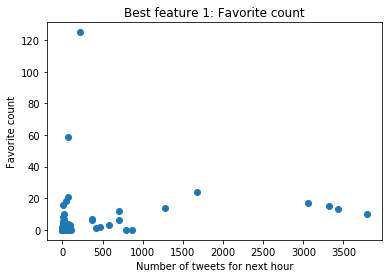

# Authors


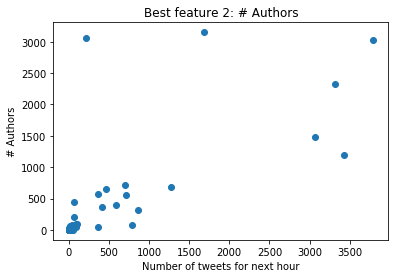

Original followers


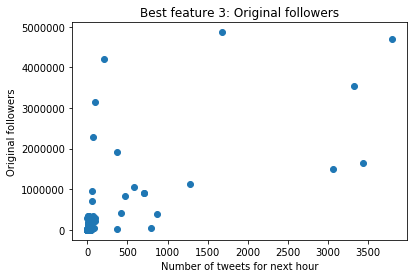

#nfl
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.760
Model:                            OLS   Adj. R-squared:                  0.754
Method:                 Least Squares   F-statistic:                     129.1
Date:                Thu, 08 Mar 2018   Prob (F-statistic):          1.47e-166
Time:                        19:43:13   Log-Likelihood:                -4453.3
No. Observations:                 586   AIC:                             8935.
Df Residuals:                     572   BIC:                             8996.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.8433      0.117      7.200    

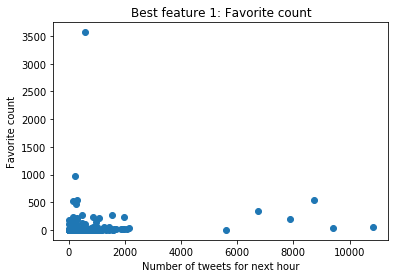

# Tweets


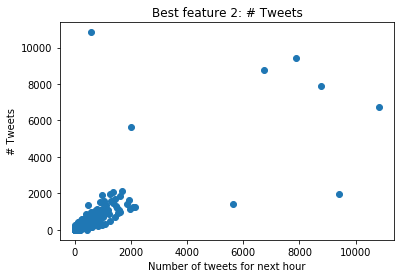

User mentions


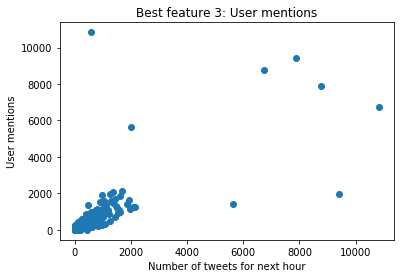

#sb49
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.822
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     187.8
Date:                Thu, 08 Mar 2018   Prob (F-statistic):          1.74e-202
Time:                        19:43:20   Log-Likelihood:                -5696.0
No. Observations:                 582   AIC:                         1.142e+04
Df Residuals:                     568   BIC:                         1.148e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -1.2904      0.301     -4.291   

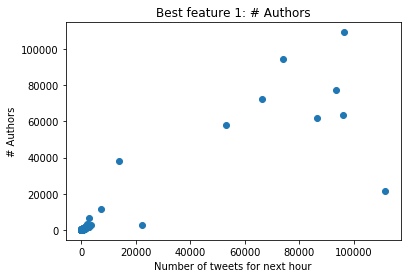

User mentions


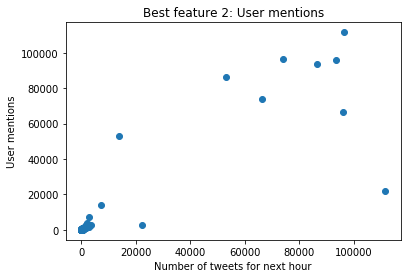

# Tweets


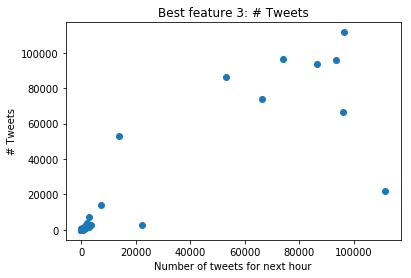

#gohawks
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.596
Model:                            OLS   Adj. R-squared:                  0.586
Method:                 Least Squares   F-statistic:                     59.54
Date:                Thu, 08 Mar 2018   Prob (F-statistic):          2.55e-101
Time:                        19:43:23   Log-Likelihood:                -4736.0
No. Observations:                 578   AIC:                             9500.
Df Residuals:                     564   BIC:                             9561.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -1.6245      0.216     -7.513

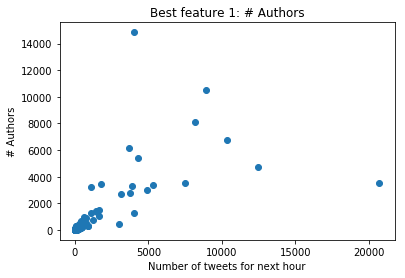

User mentions


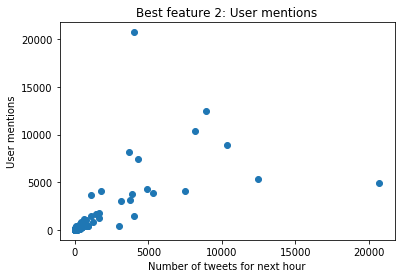

# Tweets


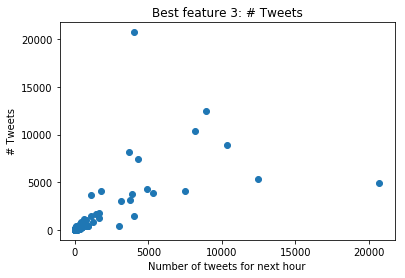

#patriots
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.738
Model:                            OLS   Adj. R-squared:                  0.732
Method:                 Least Squares   F-statistic:                     115.1
Date:                Thu, 08 Mar 2018   Prob (F-statistic):          5.88e-156
Time:                        19:43:28   Log-Likelihood:                -5365.0
No. Observations:                 586   AIC:                         1.076e+04
Df Residuals:                     572   BIC:                         1.082e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -1.5540      0.366     -4.24

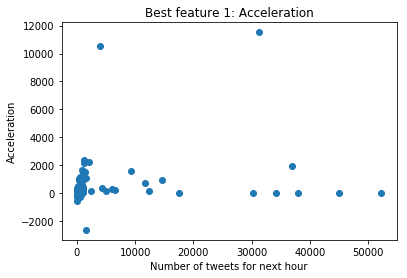

Impressions


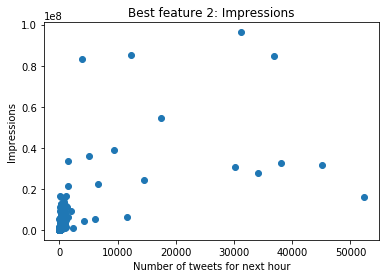

# Authors


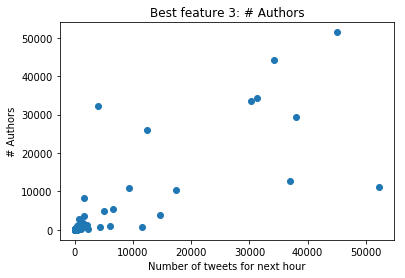

#superbowl
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.855
Method:                 Least Squares   F-statistic:                     238.4
Date:                Thu, 08 Mar 2018   Prob (F-statistic):          4.10e-223
Time:                        19:43:36   Log-Likelihood:                -5800.3
No. Observations:                 565   AIC:                         1.163e+04
Df Residuals:                     551   BIC:                         1.169e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.5383      0.199      2.7

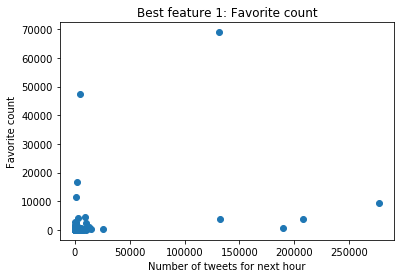

Title length


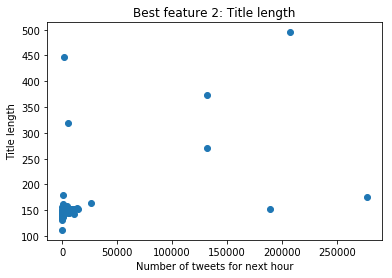

Impressions


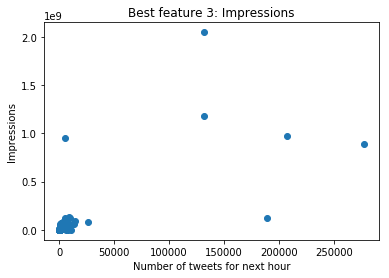

In [340]:
n_features = 15
#hashtags = ['#gopatriots']
for hashtag in hashtags:
    df = df_map[hashtag].copy()
    X, Y = getXY(df, True)
        
    X = np.nan_to_num(X[:-1])
    Y = Y[1:]
    
    stats_api.add_constant(X)
    result = stats_api.OLS(Y, X).fit()
    print(hashtag)
    print(result.summary())
    plot_func(X, Y, result)

<h2>1.4</h2>

In [354]:
def calculate_error(X, Y):
    errors = []
    for train_index, test_index in KFold(n_splits=10).split(X):
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]

        model = stats_api.OLS(Y_train, X_train).fit()
        preds = model.predict(X_test)

        errors.append(mean_absolute_error(Y_test, preds))

    return errors

In [368]:
n_features = 15
#hashtags = ['#gopatriots']
df_a = []
df_d = []
df_b = []
for hashtag in hashtags:
    print(hashtag)
    df = df_map[hashtag].copy()
    df['timestamp'] = df['timestamp'].apply(lambda x:getDate(x))
    
    before = datetime.datetime(2015,2,1,8,0,0)
    after = datetime.datetime(2015,2,1,20,0,0)
     
    df1 = df[df['timestamp'] < before]
    df2 = df[(df['timestamp'] > before) & (df['timestamp'] < after)]
    df3 = df[df['timestamp'] > after]
    
    X1, Y1 = getXY(df1)
    X2, Y2 = getXY(df2)
    X3, Y3 = getXY(df3)
    
    X1 = np.nan_to_num(X1[:-1])
    Y1 = Y1[1:]
    X2 = np.nan_to_num(X2[:-1])
    Y2 = Y2[1:]
    X3 = np.nan_to_num(X3[:-1])
    Y3 = Y3[1:]
    
    print("Average cross validation errors")
    print("Before superbowl")
    print(np.sum(calculate_error(X1, Y1))/10.0)
    print("During superbowl")
    print(np.sum(calculate_error(X2, Y2))/10.0)
    print("After superbowl")
    print(np.sum(calculate_error(X3, Y3))/10.0)
    
    df_a.append(df3)
    df_d.append(df2)
    df_b.append(df1)

#gopatriots
Average cross validation errors
Before superbowl
12.5929775302
During superbowl
275909.773526
After superbowl
379.077266144
#nfl
Average cross validation errors
Before superbowl
129.11324387
During superbowl
52827.952056
After superbowl
133.62460429
#sb49
Average cross validation errors
Before superbowl
48.216434199
During superbowl
476509.935655
After superbowl
138.287370787
#gohawks
Average cross validation errors
Before superbowl
286.483729937
During superbowl
31531.0478979
After superbowl
1435.67732912
#patriots
Average cross validation errors
Before superbowl
277.659893242
During superbowl
439411.1252
After superbowl
165.192043396
#superbowl
Average cross validation errors
Before superbowl
325.783049383
During superbowl
21397097.8066
After superbowl
336.228678845


In [375]:
df_before = pd.concat(df_b)
df_during = pd.concat(df_d)
df_after = pd.concat(df_a)

Before superbowl all hashtags
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.546
Model:                            OLS   Adj. R-squared:                  0.530
Method:                 Least Squares   F-statistic:                     33.97
Date:                Thu, 08 Mar 2018   Prob (F-statistic):           3.36e-63
Time:                        20:24:12   Log-Likelihood:                -3962.6
No. Observations:                 439   AIC:                             7955.
Df Residuals:                     424   BIC:                             8017.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             3.3872 

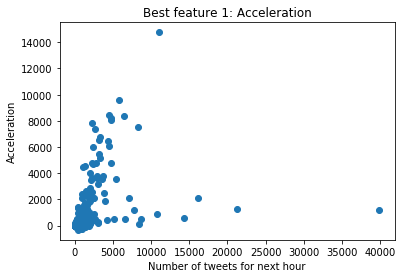

# Tweets


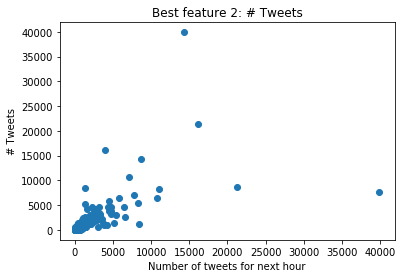

User mentions


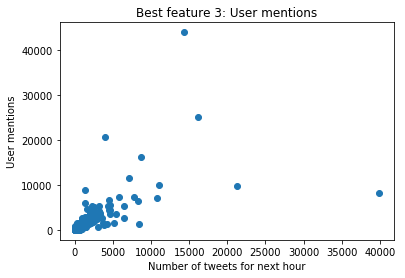

During superbowl all hashtags
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                     0.000
Date:                Thu, 08 Mar 2018   Prob (F-statistic):                nan
Time:                        20:24:13   Log-Likelihood:                 88.400
No. Observations:                  11   AIC:                            -154.8
Df Residuals:                       0   BIC:                            -150.4
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            62.0663 

/usr/local/lib/python3.6/site-packages/scipy/stats/stats.py:1390: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  "anyway, n=%i" % int(n))
/usr/local/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1392: RuntimeWarning: divide by zero encountered in true_divide
  return 1 - np.divide(self.nobs - self.k_constant, self.df_resid) * (1 - self.rsquared)
/usr/local/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1392: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - np.divide(self.nobs - self.k_constant, self.df_resid) * (1 - self.rsquared)
/usr/local/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1400: RuntimeWarning: divide by zero encountered in double_scalars
  return self.ssr/self.df_resid
/usr/local/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1353: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resi

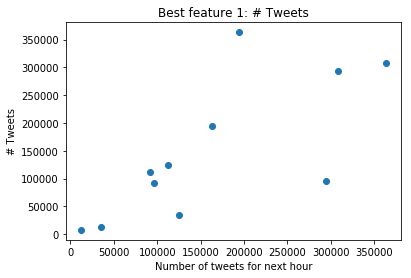

# Authors


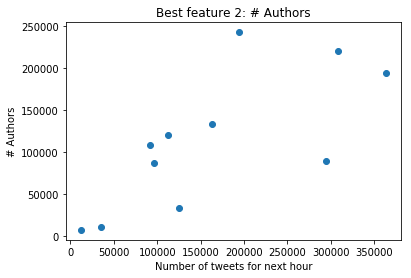

Average # Followers


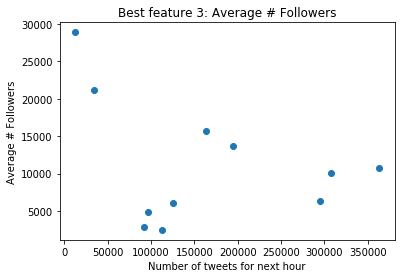

After superbowl all hashtags
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.967
Model:                            OLS   Adj. R-squared:                  0.963
Method:                 Least Squares   F-statistic:                     232.7
Date:                Thu, 08 Mar 2018   Prob (F-statistic):           1.46e-80
Time:                        20:24:13   Log-Likelihood:                -1001.8
No. Observations:                 134   AIC:                             2034.
Df Residuals:                     119   BIC:                             2077.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.6571  

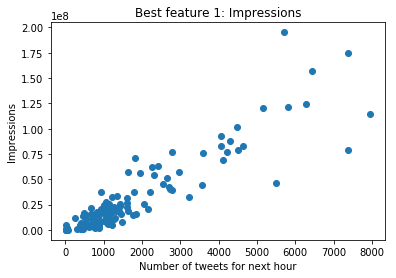

Average ranking score


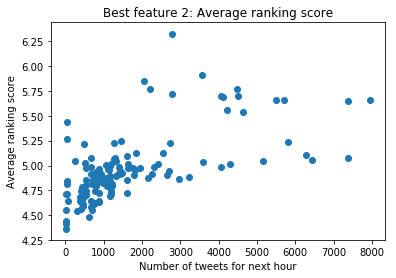

Time - Hour


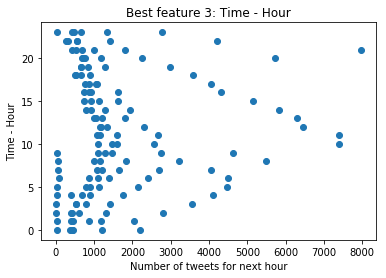

In [379]:
"""
df_all = pd.concat([df_map[hashtag] for hashtag in hashtags])
df_all['timestamp'] = df_all['timestamp'].apply(lambda x:getDate(x))
    
before = datetime.datetime(2015,2,1,8,0,0)
after = datetime.datetime(2015,2,1,20,0,0)
     
df1 = df_all[df_all['timestamp'] < before]
df2 = df_all[(df_all['timestamp'] >= before) & (df_all['timestamp'] < after)]
df3 = df_all[df_all['timestamp'] > after]
 
X1, Y1 = getXY(df1)
X2, Y2 = getXY(df2)
X3, Y3 = getXY(df3)
"""    

X1, Y1 = getXY(df_before)
X2, Y2 = getXY(df_during)
X3, Y3 = getXY(df_after)

X1 = np.nan_to_num(X1[:-1])
Y1 = Y1[1:]
X2 = np.nan_to_num(X2[:-1])
Y2 = Y2[1:]
X3 = np.nan_to_num(X3[:-1])
Y3 = Y3[1:]

print("Before superbowl all hashtags")
stats_api.add_constant(X1)
result = stats_api.OLS(Y1, X1).fit()
print(result.summary())
plot_func(X1, Y1, result)

print("During superbowl all hashtags")
stats_api.add_constant(X2)
result = stats_api.OLS(Y2, X2).fit()
print(result.summary())
plot_func(X2, Y2, result)

print("After superbowl all hashtags")
stats_api.add_constant(X3)
result = stats_api.OLS(Y3, X3).fit()
print(result.summary())
plot_func(X3, Y3, result)

In [357]:
print(hashtags)

['#gopatriots', '#nfl', '#sb49', '#gohawks', '#patriots', '#superbowl']
